In [1]:
# Data Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from tqdm import tqdm

In [2]:
PICKLEBALL_FOLDER = './pickleball_shots'
TIMESTEPS = 30   
FEATURES = 26   
BATCH_SIZE = 16
EPOCHS = 200
BASE_MODEL_PATH = './model_training/primary_tennis_model.h5'
OUT_MODEL_PATH = './model_training/primary_pickleball_model.h5'

# Load Data
In this notebook we use a dataset composed of joint positions from three different pickleball swings: forehand, backhand, and serve, as well as 'neutral' to indicate when the player is stationary or not chasing the ball. 

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X=[]
y=[]

folders = ["initial_shots", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "13", "14", "16", "17", "18", "19", "20", "21", "22", "final_shots"]

for folder in folders:
    if not os.path.exists(f"pickleball_shots/{folder}/shots/"):
        print(f"pickleball_shots/{folder}/shots/ doesnt exist")
        continue
        
    print(f"Loading shots from pickleball/{folder}/shots/")
        
    for shot_csv in tqdm(sorted(os.listdir(f'pickleball_shots/{folder}/shots/'))):
        data = pd.read_csv(os.path.join(f'pickleball_shots/{folder}/shots/', shot_csv))
        
        if folder == "nadal":
            revert_data= data.copy()
            for feature in data.columns:
                if feature[-2:]=="_x":
                    revert_data[feature] = 1 - data[feature]
            data = revert_data

        features = data.loc[:, data.columns != 'shot']

        X.append(features.to_numpy())
        y.append(data["shot"].iloc[0])
    
X = np.stack(X, axis=0)

y = np.array(y)
X = np.array(X)

print(f"Loaded {len(y)} shots for training")

pickleball_shots/initial_shots/shots/ doesnt exist
Loading shots from pickleball/1/shots/


100%|██████████| 7/7 [00:00<00:00, 70.70it/s]


Loading shots from pickleball/2/shots/


100%|██████████| 4/4 [00:00<00:00, 46.51it/s]


Loading shots from pickleball/3/shots/


100%|██████████| 14/14 [00:00<00:00, 75.27it/s]


Loading shots from pickleball/4/shots/


100%|██████████| 4/4 [00:00<00:00, 80.00it/s]


Loading shots from pickleball/5/shots/


100%|██████████| 15/15 [00:00<00:00, 77.25it/s]


pickleball_shots/6/shots/ doesnt exist
Loading shots from pickleball/7/shots/


100%|██████████| 9/9 [00:00<00:00, 83.48it/s]


Loading shots from pickleball/8/shots/


100%|██████████| 5/5 [00:00<00:00, 79.37it/s]


Loading shots from pickleball/9/shots/


100%|██████████| 13/13 [00:00<00:00, 91.15it/s]


Loading shots from pickleball/10/shots/


100%|██████████| 9/9 [00:00<00:00, 75.00it/s]


Loading shots from pickleball/13/shots/


100%|██████████| 24/24 [00:00<00:00, 82.76it/s]


Loading shots from pickleball/14/shots/


100%|██████████| 6/6 [00:00<00:00, 82.19it/s]


Loading shots from pickleball/16/shots/


100%|██████████| 9/9 [00:00<00:00, 81.08it/s]


Loading shots from pickleball/17/shots/


100%|██████████| 3/3 [00:00<00:00, 73.17it/s]


Loading shots from pickleball/18/shots/


100%|██████████| 5/5 [00:00<00:00, 35.63it/s]


Loading shots from pickleball/19/shots/


100%|██████████| 2/2 [00:00<00:00, 52.63it/s]


Loading shots from pickleball/20/shots/


100%|██████████| 25/25 [00:00<00:00, 78.59it/s]


Loading shots from pickleball/21/shots/


100%|██████████| 5/5 [00:00<00:00, 78.14it/s]


Loading shots from pickleball/22/shots/


100%|██████████| 30/30 [00:00<00:00, 84.15it/s]


Loading shots from pickleball/final_shots/shots/


100%|██████████| 12/12 [00:00<00:00, 74.92it/s]

Loaded 201 shots for training


In [16]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)


print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")

print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))

Shape of train features : (30, 26)
Shape of val features : (30, 26)
Total categories:  4
Total categories:  4


In [23]:
# Stratified split to preserve class proportions
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# Label encode consistently: fit only on train
le = preprocessing.LabelEncoder()
le.fit(y_train)

y_train_enc = le.transform(y_train)
y_val_enc   = le.transform(y_val)
# if you have y_test:
# y_test_enc = le.transform(y_test)

# One-hot encode with consistent num_classes
nb_cat = len(le.classes_)
y_train_ohe = tf.keras.utils.to_categorical(y_train_enc, num_classes=nb_cat)
y_val_ohe   = tf.keras.utils.to_categorical(y_val_enc, num_classes=nb_cat)

In [31]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_cat)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=nb_cat)

y_train = np.array(y_train)
X_train = np.array(X_train)

y_val = np.array(y_val)
X_val = np.array(X_val)

In [32]:
assert len(le.classes_) == nb_cat

In [33]:
print("X_train Shape: ", X_train.shape)
print("X_val Shape: ", X_val.shape)
print("y_train Shape: ", y_train.shape)
print("y_val Shape: ", y_val.shape)

X_train Shape:  (160, 30, 26)
X_val Shape:  (41, 30, 26)
y_train Shape:  (160, 4)
y_val Shape:  (41, 4)


Now we must encode our training labels

# Load Weights from Tennis Model

In [34]:
from tensorflow.keras.optimizers import Adam

# 5) Load pretrained model and adapt output if needed
model = load_model(BASE_MODEL_PATH)
print("Loaded base model:")
model.summary()

# Freeze early layers (adjust how many to freeze)
for layer in model.layers[:-1]:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
#model.evaluate(X_val, y_val)

Loaded base model:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 32)            7552      
                                                                 
 batch_normalization_9 (Batc  (None, 30, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 24)                5472      
                                                                 
 batch_normalization_10 (Bat  (None, 24)               96        
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None,

# Transfer Learn

In [35]:
# 6) Train / callbacks
ckpt = ModelCheckpoint(OUT_MODEL_PATH, save_best_only=True, monitor='val_accuracy', verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(X_train, y_train_ohe,
                    validation_data=(X_val, y_val_ohe),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[ckpt, es],
                    verbose=1)

Epoch 1/200


 8/10 [=======================>......] - ETA: 0s - loss: 1.4015 - accuracy: 0.6953 
Epoch 1: val_accuracy improved from -inf to 0.70732, saving model to ./model_training\primary_pickleball_model.h5
10/10 [==============================] - 4s 115ms/step - loss: 1.3433 - accuracy: 0.7063 - val_loss: 1.1765 - val_accuracy: 0.7073
Epoch 2/200
 7/10 [====================>.........] - ETA: 0s - loss: 1.2581 - accuracy: 0.7321
Epoch 2: val_accuracy did not improve from 0.70732
10/10 [==============================] - 0s 14ms/step - loss: 1.2267 - accuracy: 0.7312 - val_loss: 1.1758 - val_accuracy: 0.7073
Epoch 3/200
 9/10 [==========================>...] - ETA: 0s - loss: 1.2814 - accuracy: 0.7222
Epoch 3: val_accuracy did not improve from 0.70732
10/10 [==============================] - 0s 11ms/step - loss: 1.3022 - accuracy: 0.7125 - val_loss: 1.1752 - val_accuracy: 0.7073
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.7250
Epoch 4: val_accuracy di

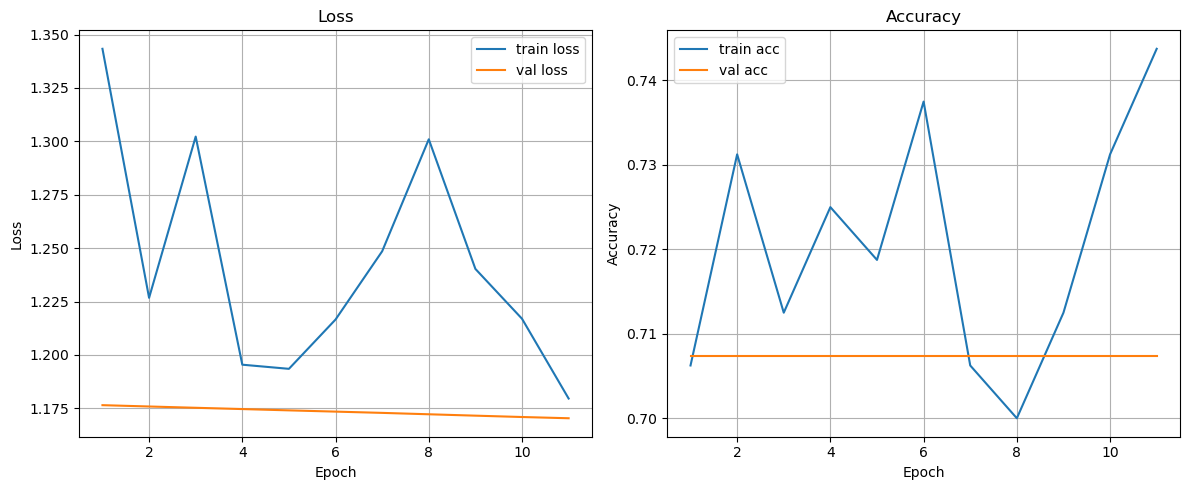

In [36]:
import matplotlib.pyplot as plt

def plot_training_history(history, figsize=(12, 5)):
    """
    Plot training & validation loss and accuracy from a Keras `history` (History object or dict).
    Usage: plot_training_history(history)
    """
    # Accept either Keras History object or plain dict
    hist = history.history if hasattr(history, "history") else history
    if not hist or "loss" not in hist:
        raise ValueError("Provided `history` has no 'loss' data. Pass the History returned by model.fit.")

    # detect accuracy keys (TF/Keras versions differ)
    acc_key = "accuracy" if "accuracy" in hist else ("acc" if "acc" in hist else None)
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else ("val_acc" if "val_acc" in hist else None)

    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=figsize)

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist.get("loss", []), label="train loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Accuracy (if available)
    plt.subplot(1, 2, 2)
    if acc_key is not None or val_acc_key is not None:
        if acc_key is not None:
            plt.plot(epochs, hist.get(acc_key, []), label="train acc")
        if val_acc_key is not None:
            plt.plot(epochs, hist.get(val_acc_key, []), label="val acc")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No accuracy data in history", ha="center", va="center")
        plt.title("Accuracy (not available)")

    plt.tight_layout()
    plt.show()

# Example:
plot_training_history(history)

In [ ]:
# 7) Evaluate & save final model name if not saved by checkpoint
model.save(OUT_MODEL_PATH)
print("Saved fine-tuned model to", OUT_MODEL_PATH)